# Project Description

Goal :
*   Predict which passenger survived the Titanic shopwreck
*   Prepare the data for analysis
    * Remove the outstanding data
    * Normalize and standardis data
    * Replace or remove the NaN data
* Find features with significant differences
* Remove the features which has high correlation
* Check the Power of the data



> Add blockquote



In [1]:
import pandas as pd
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from scipy.stats import chi2_contingency # for nonnormal categoriacal features
from scipy.stats import mannwhitneyu # for non normal numerical and categorical (binary data)

# Encoding
from sklearn.preprocessing import LabelEncoder # Use if you can make the values in order (small, mid, big), for DecisionTree or Neural network
# Or One-Hot Encoder: If ther is not order in the value (.get_dummies())

# Normalization vs Standardisation
from sklearn.preprocessing import MinMaxScaler # Normalization: If data is pozitive and there is no to much outlier. (Data will be between 0 and 1)
from sklearn.preprocessing import StandardScaler # Standardisation: For pozitive and negative data, there are outliers and need a normal data (0 will be the mean in the std data)

from sklearn.preprocessing import PowerTransformer

In [2]:
from google.colab import drive
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Pytorch pet projects/ML - Projecs/ML - Titanic - Machine Learning from Disaster"
sys.path.append(os.path.join(project_path, "src"))

Mounted at /content/drive


## Import raw data
* First look on the data
* Data Description
* Look into the missing datas

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Pytorch pet projects/ML - Projects/ML - Titanic - Machine Learning from Disaster/data/raw/titanic/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Pytorch pet projects/ML - Projects/ML - Titanic - Machine Learning from Disaster/data/raw/titanic/test.csv")
df_gen_sub = pd.read_csv("/content/drive/MyDrive/Pytorch pet projects/ML - Projects/ML - Titanic - Machine Learning from Disaster/data/raw/titanic/gender_submission.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


## Handle missing data


In [7]:
missing_age = df[df["Age"].isna()]
missing_age.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177 entries, 5 to 888
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  177 non-null    int64  
 1   Survived     177 non-null    int64  
 2   Pclass       177 non-null    int64  
 3   Name         177 non-null    object 
 4   Sex          177 non-null    object 
 5   Age          0 non-null      float64
 6   SibSp        177 non-null    int64  
 7   Parch        177 non-null    int64  
 8   Ticket       177 non-null    object 
 9   Fare         177 non-null    float64
 10  Cabin        19 non-null     object 
 11  Embarked     177 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 18.0+ KB


### Question 1: how to fiel out the missing Age feature ?

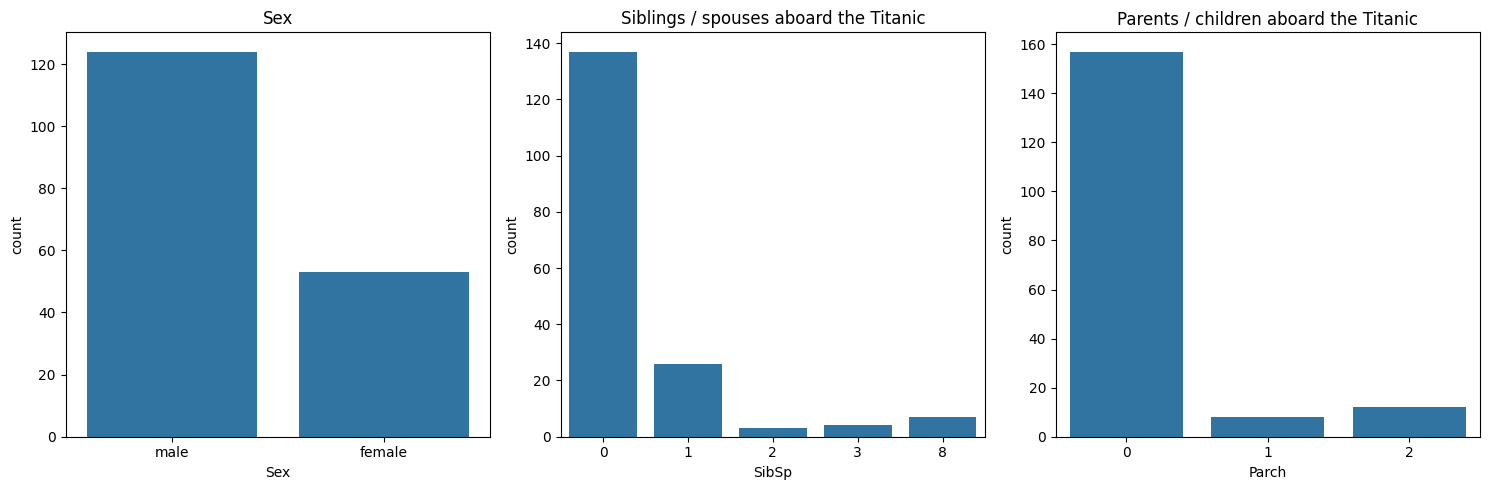

In [8]:
# It looks like most of the passengers whose age is unknown were male and traveled alone on the Titanic.
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.countplot(x=missing_age["Sex"], ax=axes[0])
axes[0].set_title("Sex")
sns.countplot(x=missing_age["SibSp"], ax=axes[1])
axes[1].set_title("Siblings / spouses aboard the Titanic")
sns.countplot(x=missing_age["Parch"], ax=axes[2])
axes[2].set_title("Parents / children aboard the Titanic")

plt.tight_layout()
plt.show()

In [9]:
# Lets check if is there a difference between the mean and median age of solo male travelers and that of all passengers.
single_trev_male = df[(df["Age"].notna()) & (df["Sex"] == "male") & (df["SibSp"] == 0) & (df["Parch"] == 0)]
mean_solo_trev_male = single_trev_male["Age"].mean()
median_solo_trev_male = single_trev_male["Age"].median()

print(f"Mean age of solo male: {mean_solo_trev_male:.3f}")
print(f"Median age of solo male: {median_solo_trev_male}")

print(f"Mean age of passangers: {df[df['Age'].notna()]['Age'].mean():.3f}")
print(f"Mean age of passangers: {df[df['Age'].notna()]['Age'].median()}")



Mean age of solo male: 32.901
Median age of solo male: 30.0
Mean age of passangers: 29.699
Mean age of passangers: 28.0


### Conclusion:
* Age: It looks like there is no difference between the mean and median age of solo male travelers and that of all passengers. So lets just replace the nan values with the median

### Question 2: Does the cabin number affect the possibility of a passenger's survival?

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [11]:
df_cab = df[df["Cabin"].notna()]

condition = [
    df_cab["Cabin"].str.contains("A"),
    df_cab["Cabin"].str.contains("B"),
    df_cab["Cabin"].str.contains("C"),
    df_cab["Cabin"].str.contains("D"),
    df_cab["Cabin"].str.contains("E"),
]
values = [1,2,3,4,5]

df_cab["Cabin_cat"] = np.select(condition, values, default=0)

<ipython-input-11-b49ff7053e51>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cab["Cabin_cat"] = np.select(condition, values, default=0)


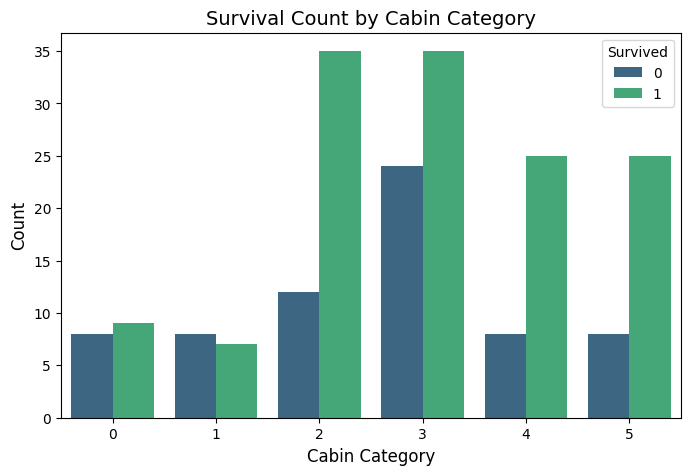

In [12]:
# Create the countplot
plt.figure(figsize=(8,5))  # Adjust figure size for better readability
sns.countplot(x="Cabin_cat", hue="Survived", data=df_cab, palette="viridis")

# Add title and labels
plt.title("Survival Count by Cabin Category", fontsize=14)
plt.xlabel("Cabin Category", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Show the plot
plt.show()


### Conclusion:
* It looks like there are more survivors with a cabin number starting with C, D, or E. However, I decided to simply fill in the NaN values with the same value, 'X'.

### ! Fill out the missing values based on our conclusions

In [13]:
df["Cabin"].fillna("X", inplace=True)
df["Age"].fillna(np.median(df["Age"].dropna()), inplace=True);
df["Embarked"].fillna("S", inplace=True)
df.isna().sum()

<ipython-input-13-f8d2cfc62a75>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Cabin"].fillna("X", inplace=True)
<ipython-input-13-f8d2cfc62a75>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.metho

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


## Is there any outliers ?

MIn: 0.42, Median: 28.0, Max: 80.0 age 


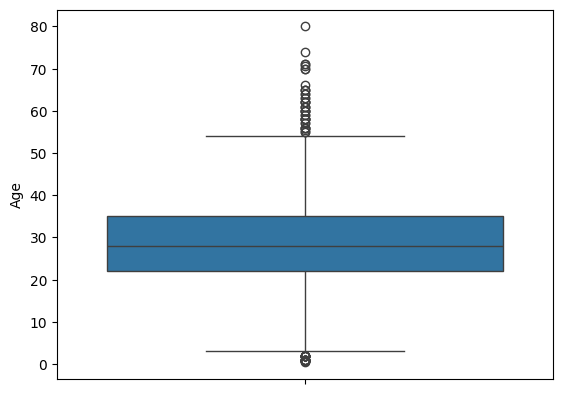

In [14]:
sns.boxplot(y="Age", data=df);
min = df["Age"].min()
median = df["Age"].median()
max = df["Age"].max()
print(f"MIn: {min}, Median: {median}, Max: {max} age ")

### Conclusion:
* There are outliers, but this data looks legitimate, so I will not remove them.

## ! Change data types:
* Change the data type of features to categorical if appropriate.

In [15]:
unq_emb = df["Embarked"].unique()
unq_sex = df["Sex"].unique()
print(f"Unique values of the Embarked: {unq_emb}")
print(f"Unique values of the Sex: {unq_sex}")

# Turn object type into categorical
df[["Sex", "Embarked"]] = df[["Sex", "Embarked"]].astype('category')
df.info()

Unique values of the Embarked: ['S' 'C' 'Q']
Unique values of the Sex: ['male' 'female']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        891 non-null    object  
 11  Embarked     891 non-null    category
dtypes: category(2), float64(2), int64(5), object(3)
memory usage: 71.7+ KB


## ! Remove the unsued features
* There are some features which we wont use to predict the pessanger survived or not, these are the **Ticket number**, **Cabin**, **Name**, **PassengerId**

In [16]:
df.drop(columns=["PassengerId", "Name", "Cabin", "Ticket"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    int64   
 1   Pclass    891 non-null    int64   
 2   Sex       891 non-null    category
 3   Age       891 non-null    float64 
 4   SibSp     891 non-null    int64   
 5   Parch     891 non-null    int64   
 6   Fare      891 non-null    float64 
 7   Embarked  891 non-null    category
dtypes: category(2), float64(2), int64(4)
memory usage: 43.9 KB


## Save processed data

In [18]:
df.to_csv("/content/drive/MyDrive/Pytorch pet projects/ML - Projects/ML - Titanic - Machine Learning from Disaster/data/processed/processed_data.csv")

## Visulizing, find relationships between features

### Is there a relationship between the survivor's sex and the fare they paid for the ticket?

As we can see, there is a relationship between sex and the possibility of survival.


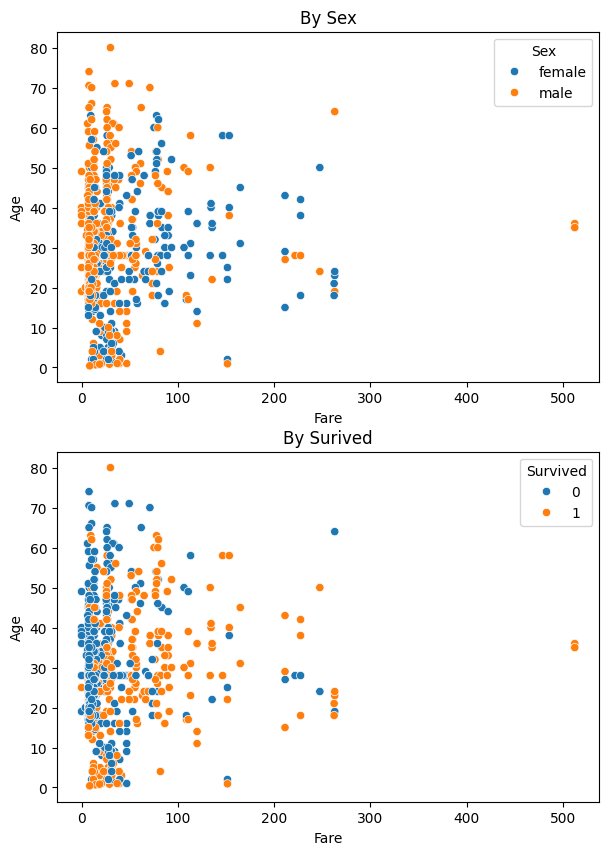

In [ ]:
fig, axes = plt.subplots(2,1, figsize=(7,10))

sns.scatterplot(x="Fare",
                y="Age",
                data=df,
                hue="Sex",
                ax=axes[0])
axes[0].set_title("By Sex")

# fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.scatterplot(x="Fare",
                y="Age",
                data=df,
                hue="Survived",
                ax=axes[1])
axes[1].set_title("By Surived")

print("As we can see, there is a relationship between sex and the possibility of survival.")

### Is there a higher chance of survival on the Titanic if your family is also there?

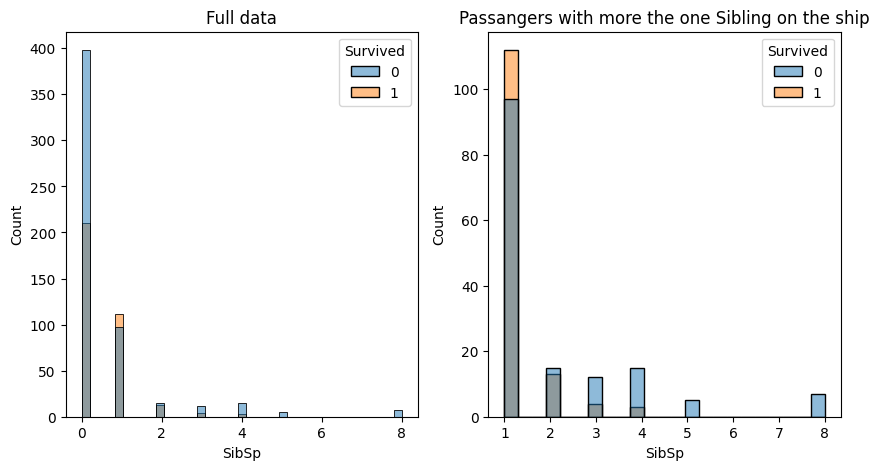

Looks like you have more chanse to surviv if have one or two partner


In [ ]:
not_alone_sibSp = df[df["SibSp"]>0]

fig, axes = plt.subplots(1,2, figsize=(10,5))

sns.histplot(x="SibSp", data=df, hue="Survived", ax=axes[0])
axes[0].set_title("Full data")
sns.histplot(x="SibSp", data=not_alone_sibSp, hue="Survived", ax=axes[1])
axes[1].set_title("Passangers with more the one Sibling on the ship")

plt.show()
print("Looks like you have more chanse to surviv if have one or two partner")

There is a relationship between the number of siblings or parents and the chance of surviving the shipwreck.


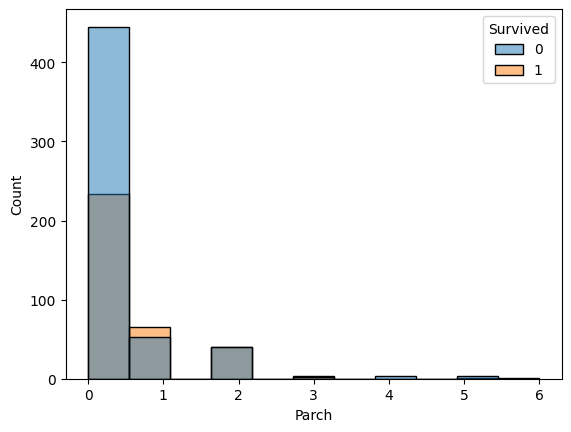

In [ ]:
sns.histplot(x="Parch", data=df, hue="Survived")
print(f"There is a relationship between the number of siblings or parents and the chance of surviving the shipwreck.")

In [ ]:
print(df.groupby("SibSp")["Survived"].mean())
print(df.groupby("Parch")["Survived"].mean())

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64
Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64


In [ ]:
sibsp_table = pd.crosstab(df["SibSp"], df["Survived"])
parch_table = pd.crosstab(df["Parch"], df["Survived"])

chi2_sibsp, p_sibsp, _, _ = chi2_contingency(sibsp_table)
chi2_parch, p_parch, _, _ = chi2_contingency(parch_table)

print(f"SibSp Chi2: {chi2_sibsp}, p-value: {p_sibsp:.6f}")
print(f"Parch Chi2: {chi2_parch}, p-value: {p_parch:.6f}")

SibSp Chi2: 37.2717929152043, p-value: 0.000002
Parch Chi2: 27.925784060236168, p-value: 0.000097


### Conclusion:
* A passenger had the highest chance of surviving the shipwreck if they were not alone on the ship.
* However, if the family was too large (>3), their chances were smaller compared to those who traveled alone.

### Is there a higher chance of survival if you are younger?

There is a big changse to survive if your in our 20th 30th


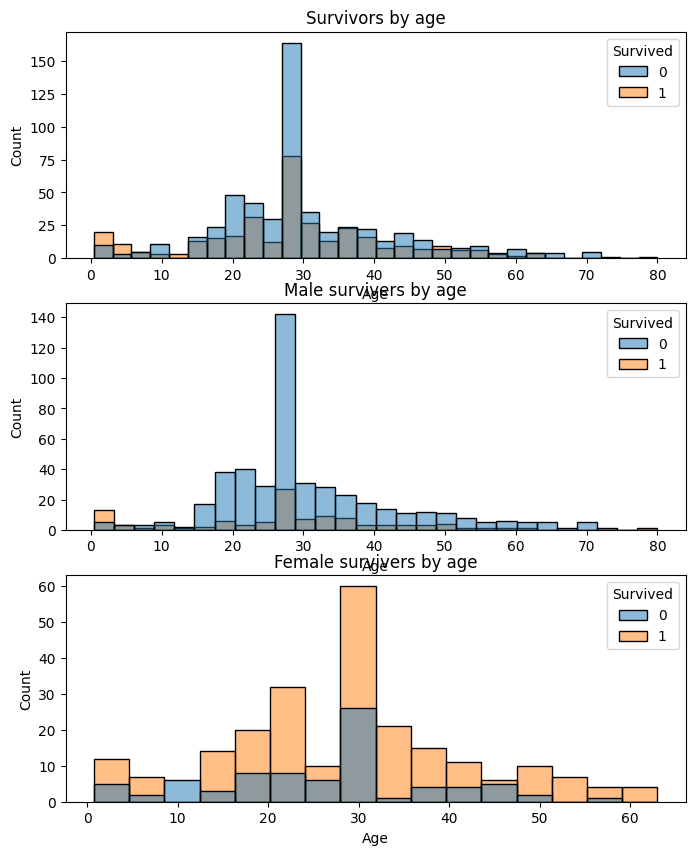

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(8,10))

sns.histplot(x="Age", data=df, hue="Survived", ax=axes[0])
axes[0].set_title("Survivors by age")

sns.histplot(x="Age", data=df[df["Sex"] == 'male'], hue="Survived", ax=axes[1])
axes[1].set_title("Male survivers by age")

sns.histplot(x="Age", data=df[df["Sex"] == 'female'], hue="Survived", ax=axes[2])
axes[2].set_title("Female survivers by age")

print(f"There is a big changse to survive if your in our 20th 30th")

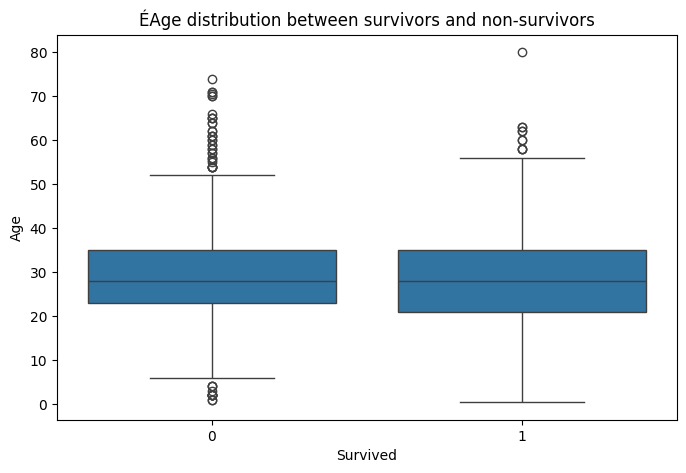

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df["Survived"], y=df["Age"])
plt.xlabel("Survived")
plt.ylabel("Age")
plt.title("ÉAge distribution between survivors and non-survivors")
plt.show()


In [ ]:
sur_age = df[df["Survived"] == 1]["Age"]
no_sur_age = df[df["Survived"] == 0]["Age"]

u_stat, p_val = mannwhitneyu(sur_age, no_sur_age, alternative="two-sided")
print(f"u_stat: {u_stat:.2f}, p_value: {p_val:.2f}")

u_stat: 89779.50, p_value: 0.27


### Conclution:
* p_value > 0.05 which means that the age is not that important for us to predict who is the surviver and who is not

### Is there a relationship between wealth/poverty and the survivers ?
* Let's assume that a passenger is wealthy if their ticket price is ower the upper bound.

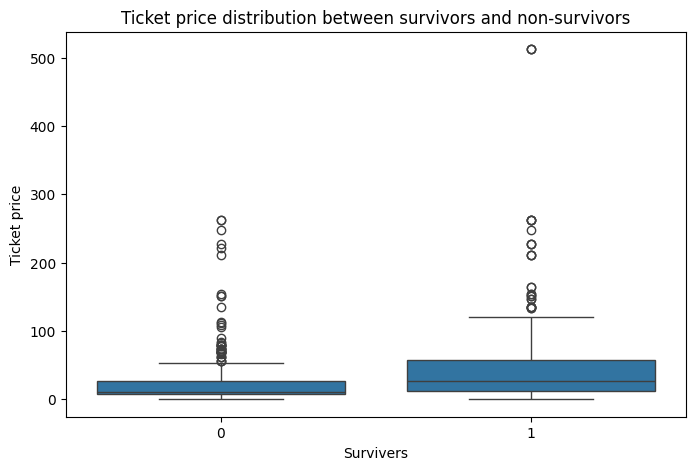

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df["Survived"], y=df["Fare"])
plt.xlabel("Survivers")
plt.ylabel("Ticket price")
plt.title("Ticket price distribution between survivors and non-survivors")
plt.show()

Looks like more wealthy poeple survived in a higher number then others


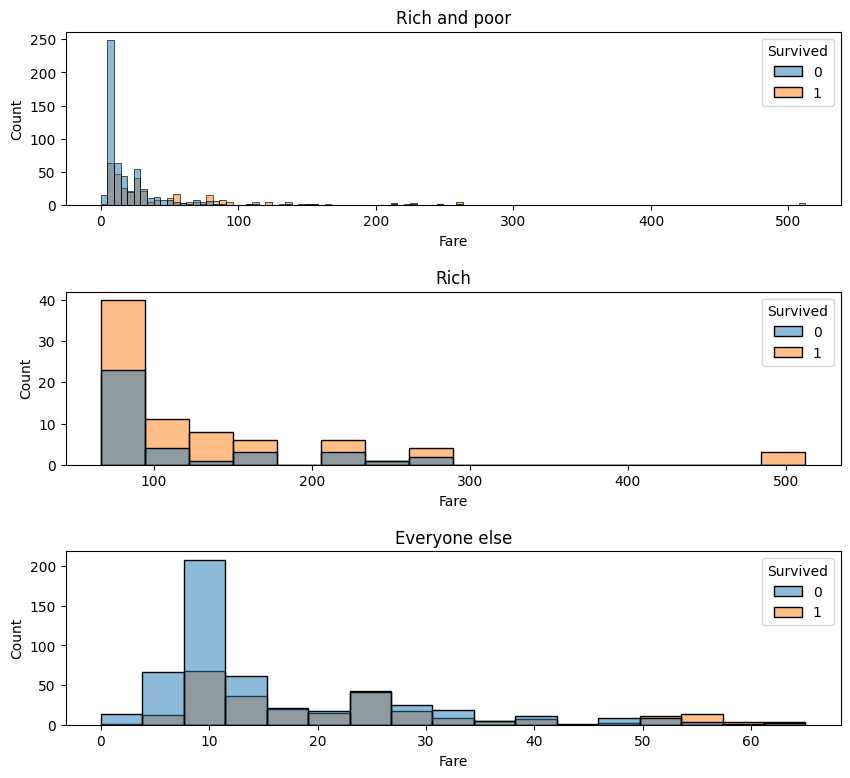

In [ ]:
# Calculat the upper bound by using IQR
Q1 = df["Fare"].quantile(0.25)
Q3 = df["Fare"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
df_wealthy = df[df["Fare"] > upper_bound]
df_middle = df[df["Fare"] < upper_bound]


fig, axes = plt.subplots(3, 1, figsize=(10,9))
fig.subplots_adjust(hspace=0.5)

sns.histplot(x="Fare", data=df, hue="Survived", ax=axes[0])
axes[0].set_title("Rich and poor")

sns.histplot(x="Fare", data=df_wealthy, hue="Survived", ax=axes[1])
axes[1].set_title("Rich")

sns.histplot(x="Fare", data=df_middle, hue="Survived", ax=axes[2])
axes[2].set_title("Everyone else")

print("Looks like more wealthy poeple survived in a higher number then others")

Text(0.5, 1.0, 'Other male passangers')

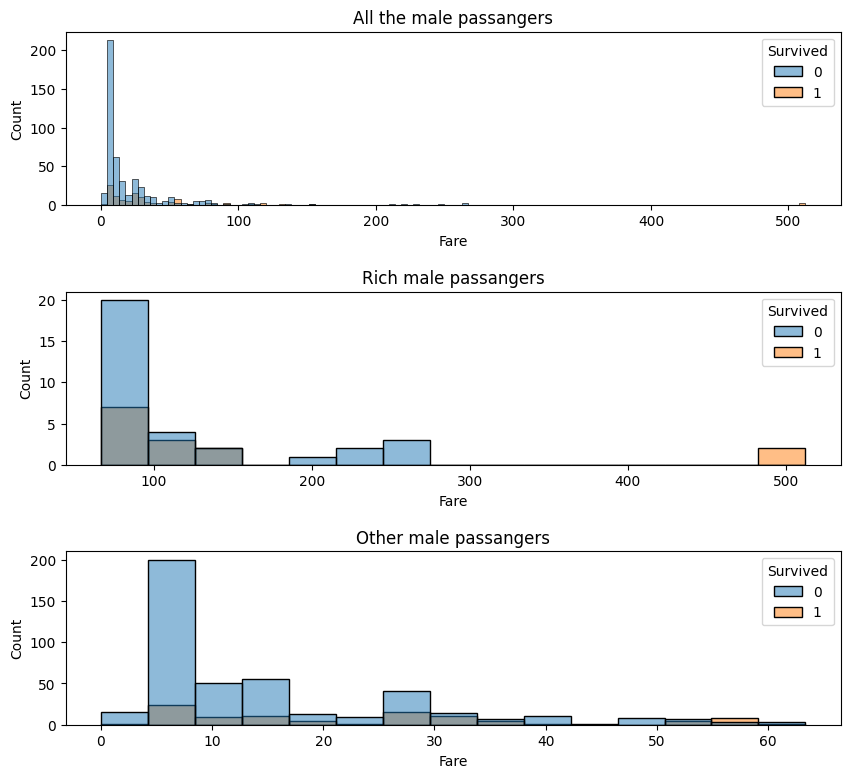

In [ ]:
df_male_wealthy = df[(df["Fare"] > upper_bound) & (df["Sex"] == 'male')]
df_male_middle = df[(df["Fare"] < upper_bound) & (df["Sex"] == 'male')]

fig, axes = plt.subplots(3, 1, figsize=(10,9))
fig.subplots_adjust(hspace=0.5)

sns.histplot(x="Fare", data=df[df["Sex"] == "male"], hue="Survived", ax=axes[0])
axes[0].set_title("All the male passangers")

sns.histplot(x="Fare", data=df_male_wealthy, hue="Survived", ax=axes[1])
axes[1].set_title("Rich male passangers")

sns.histplot(x="Fare", data=df_male_middle, hue="Survived", ax=axes[2])
axes[2].set_title("Other male passangers")

In [ ]:
# Lets check if ther is a significant relationship between the Fare and the target
sur_group = df[df["Survived"] == 1]["Fare"]
no_sur_group = df[df["Survived"] == 0]["Fare"]

u_stats, p_value = mannwhitneyu(sur_group, no_sur_group, alternative="two-sided")
print(f"u_stats : {u_stats:.6}, p_value: {p_value:.10f}")

u_stats : 1.29952e+05, p_value: 0.0000000000


### Conclution:
* There is a significant diff between Fare and target feature
* This could mean that passengers who paid more for their ticket had a higher chance of surviving the shipwreck

### Is there a higher chance of survival if you are from a specific class?

PClass Chi2: 102.888989, p-value: 0.000097


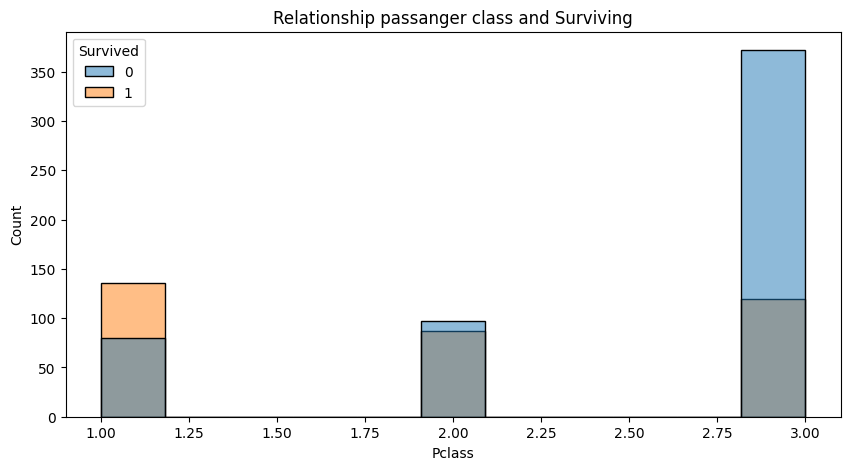

In [ ]:
pclass_table = pd.crosstab(df["Pclass"], df["Survived"])
chi2_pclass, p_pclass, _, _ = chi2_contingency(pclass_table)
print(f"PClass Chi2: {chi2_pclass:.6f}, p-value: {p_parch:.6f}")


fig, axes = plt.subplots(1,1, figsize=(10,5))
sns.histplot(x="Pclass", data=df, ax=axes, hue="Survived")
axes.set_title("Relationship passanger class and Surviving");

### Conclution:
* It is clear that there is a strong relationship between a passenger's class and the possibility of surviving the shipwreck.

## Lets find the correlations

<Axes: >

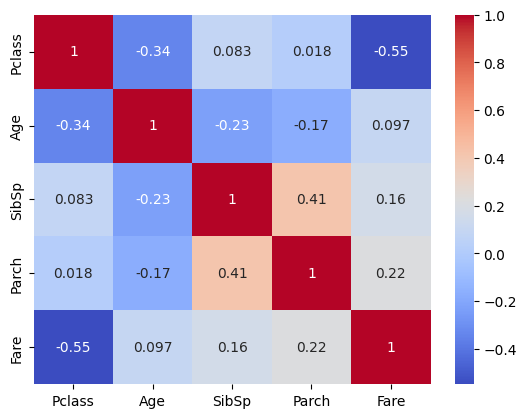

In [ ]:
df_nums = df.drop(columns=["Sex", "Embarked", "Survived"])
sns.heatmap(df_nums.corr(), annot=True, cmap='coolwarm')

### Conclusion:
* We cannot find any strong correlation between the features, so no further action is needed

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    int64   
 1   Pclass    891 non-null    int64   
 2   Sex       891 non-null    category
 3   Age       891 non-null    float64 
 4   SibSp     891 non-null    int64   
 5   Parch     891 non-null    int64   
 6   Fare      891 non-null    float64 
 7   Embarked  891 non-null    category
dtypes: category(2), float64(2), int64(4)
memory usage: 43.9 KB


## Is ther a significant difference between Parch and SibSp ?
* From the heatmap we can see that the highest correlation is between Parch and SibSp. is there a significant difference between these two features ?

## !Encoding

In [ ]:
le = LabelEncoder()
df["Sex_encoded"] = le.fit_transform(df["Sex"])
df.drop(columns=["Sex"], axis=1, inplace=True)
df = pd.get_dummies(df, columns=["Embarked"], drop_first=True)

In [ ]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_encoded,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,False,True
1,1,1,38.0,1,0,71.2833,0,False,False
2,1,3,26.0,0,0,7.9250,0,False,True
3,1,1,35.0,1,0,53.1000,0,False,True
4,0,3,35.0,0,0,8.0500,1,False,True


## ! Power Transformation: to make data normal
* Will be used on Fare and Age

<Axes: xlabel='Age', ylabel='Count'>

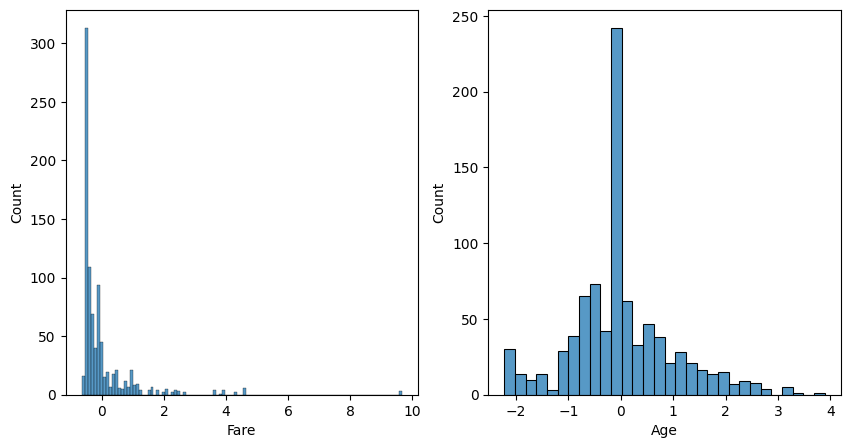

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
sns.histplot(x="Fare", data=df, ax=axes[0])

sns.histplot(x="Age", data=df, ax=axes[1])

In [ ]:
pt = PowerTransformer(method='yeo-johnson')
df[["Fare", "Age"]] = pt.fit_transform(df[["Fare", "Age"]])

<Axes: xlabel='Age', ylabel='Count'>

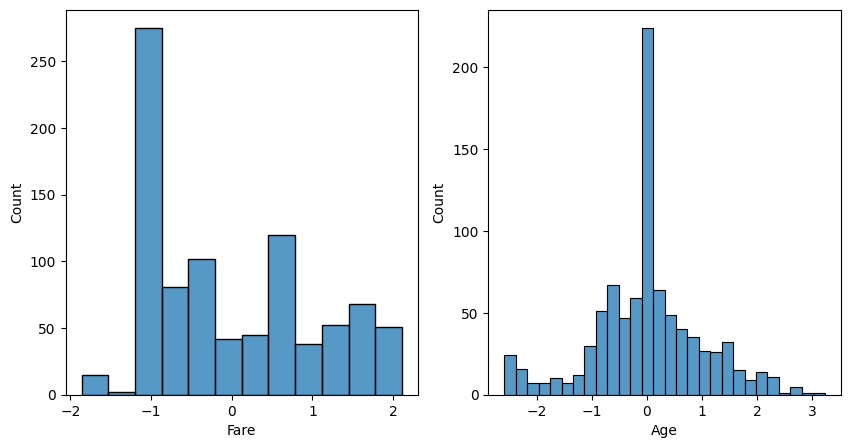

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
sns.histplot(x="Fare", data=df, ax=axes[0])

sns.histplot(x="Age", data=df, ax=axes[1])

## ! Normalization and Standardization

In [ ]:
scaler = StandardScaler()
df[["Fare", "Age"]] = scaler.fit_transform(df[["Fare", "Age"]])